<a href="https://pangeos.eu/" target="_blank">
<center><img src="../images/1-logos-pan-eu-cost.png" alt="logos" width="100%"/></center>
</a>

PANGEOS summer taining school 2024

EXAMPLE OF UNCERTAINTY PROPAGATION FOR 

# CASE 3: Propagation of retrieved traits to higher level products

**Authors:**
Andreas Hueni (andreas.hueni@geo.uzh.ch), Mike Werfeli (mike.werfeli@geo.uzh.ch) and Egor Prikaziuk (e.prikaziuk@utwente.nl)

<div class="alert alert-success">
Using SCOPE from MATLAB is easy once you have a MATLAB license.
</div>

<div class="alert alert-warning">
Calling MATLAB from Python is complicated because <strong>matlab-python bridge</strong> requires a matching Python version.
</div>

If you can not run this example it is ok. 

There's another notebook that shows how to propagate the uncertainty throgh SCOPE purely from the distributions of parameters, outside punpy and covariances

# Learning objectives

**After follwing this notebook you will be able to ...**
- propagate uncertainty in the retrieved traits (LAI) to the uncertainty in the higher level model outputs (LAI)
- propagate uncertainty through complex models 


# TOC

1. [Introduction](#1)
2. [Propagate uncertainty](#2)
    1. [2-1](#2-1) Monte Carlo sampler initialization
    2. [2-2](#2-2) model function definition
    3. [2-3](#2-3) mean value computation
    4. [2-4](#2-4) uncertainty definition
    5. [2-5](#2-5) uncertinaty propagation
3. [Meaning](#3)
    1. [3-1](#3-1) in words
    2. [3-2](#3-2) graphically

# 1 
## Introduction 
[back to TOC](#TOC)

This notebook shows that `punpy` package is capable of propagating uncertainty through complex functions and models that are not even written in Python.

For that you have to have the `matlabengine` package installed, along with MATLAB and the SCOPE model. Please, refer to the [case_3-Ex1.1-Run_SCOPE_from_Python.ipynb](case_3-Ex1.1-Run_SCOPE_from_Python.ipynb) notebook

In [1]:
%%time
import matlab.engine
eng = matlab.engine.start_matlab()

CPU times: total: 672 ms
Wall time: 39.7 s


In [2]:
from importlib.metadata import version
version('punpy')

'1.0.1'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import punpy

from pathlib import Path

plt.rcParams.update({'font.size': 16})

# 2
## Uncertainty propagation with punpy
[back to TOC](#TOC)

### 2-1 
#### Monte Carlo sampler initialization
[back to TOC](#TOC)

SCOPE model is slow (~1 second per run) => it takes too long to run 10 000 samples as before, let's limit it to 100

In [4]:
prop = punpy.MCPropagation(100)

### 2-2
#### wrapper function definition
[back to TOC](#TOC)

These are steps from the previous notebook [case_3-Ex1.1-Run_SCOPE_from_Python.ipynb](case_3-Ex1.1-Run_SCOPE_from_Python.ipynb)  wrapped in a function to call with punpy

Our target variables (SCOPE outputs) for which we want to get the uncertainty are
- GPP - gross primary productivity, photosynthesis
- LST - land surface temperature

In [5]:
# provide here full path to the SCOPE model folder, the one where SCOPE.m file is
path_scope = Path(r'C:\Users\PrikaziukE\Downloads\SCOPE-master')

def run_scope(LAIs, eng=eng, path_scope=path_scope):
    """
    define function to call SCOPE, passsing the arguments to pass via CSV file
    returns GPP and LST in an array
    """

    print('Running SCOPE!')

    path_csv = path_scope / 'set_parameter_filenames.csv'

    df = pd.read_csv(path_csv, header=None)
    df.iloc[0, 2] = 'input_data_default.csv'
    df.to_csv(path_csv, header=False, index=False)    

    path_csv = path_scope / 'input' / 'setoptions.csv'

    df = pd.read_csv(path_csv, header=None)
    df.loc[df[1] == 'verify', 0] = 0
    df.to_csv(path_csv, header=False, index=False)

    path_csv = path_scope / 'input' / 'input_data_default.csv'
    df = pd.read_csv(path_csv, header=None, index_col=0)
    df = df[[1]]

    var_name = 'LAI'
    df_insert = pd.DataFrame([LAIs], index=[var_name])
    df_insert.columns += 2  # to avoid duplicated column error on join
    
    df = df.join(df_insert)
    df.to_csv(path_csv, header=False)

    eng.cd(path_scope.as_posix(), nargout=0)
    eng.SCOPE(nargout=0)
    output_dir = eng.workspace['Output_dir']

    path_output = path_scope / output_dir

    df = pd.read_csv(path_output / 'vegetation.csv', skiprows=[1, 2])  # 1 - units, 2 - value we did not change

    return np.array([df.GPP, df.LST])

### 2-3
#### mean value computation
[back to TOC](#TOC)

In [6]:
# an example on how to use the scope encapsulation function
LAI_values = np.array(2.5)

GPP, LST = run_scope(LAI_values)
GPP, LST

Running SCOPE!


(array([19.76428]), array([296.3763]))

### 2-4 
#### uncertainty quantification
[back to TOC](#TOC)

Here relative uncertainty of 3% is assumed.

You can use standard deviation of retrieved LAI from the code of Jose [09-PiccoloDoppioInversion.ipynb](https://github.com/pangeos-cost/pangeos_uq/blob/main/notebooks/09-PiccoloDoppioInversion.ipynb)

In [7]:
LAI_uncertainties_random = LAI_values * 0.05  # random uncertainty of 5 %

### 2-5
#### uncertainty propagation
[back to TOC](#TOC)

function help https://punpy.readthedocs.io/en/latest/content/generated/punpy.mc.mc_propagation.MCPropagation.propagate_random.html#punpy.mc.mc_propagation.MCPropagation.propagate_random

In [8]:
%%time
GPP_ur, LST_ur = prop.propagate_random(run_scope, 
                                       [LAI_values], 
                                       [LAI_uncertainties_random])

Running SCOPE!
Running SCOPE!
CPU times: total: 406 ms
Wall time: 17.9 s


In [9]:
GPP_ur, LST_ur

(0.6635838967619618, 0.045332892815263155)

# 3
## meaning
[back to TOC](#TOC)

## 3-1
### in numbers
[back to TOC](#TOC)

In [10]:
print(f'LAI = {LAI_values:.2f} +/- {LAI_uncertainties_random:.2f}' + ' m2 m-2')

LAI = 2.50 +/- 0.12 m2 m-2


In [11]:
print(f'GPP = {GPP[0]:.2f} +/- {GPP_ur:.2f}' + ' umol CO2 m-2 s-1')

GPP = 19.76 +/- 0.66 umol CO2 m-2 s-1


In [12]:
print(f'LST = {LST[0]:.2f} +/- {LST_ur:.2f}' + ' K')

LST = 296.38 +/- 0.05 K


In [13]:
print(f'relative LAI uncertainty is {LAI_uncertainties_random / LAI_values * 100:.1f}%')
print(f'relative GPP uncertainty is {GPP_ur / GPP[0] * 100:.1f}%')
print(f'relative LST uncertainty is {LST_ur / LST[0] * 100:.1f}%')

relative LAI uncertainty is 5.0%
relative GPP uncertainty is 3.4%
relative LST uncertainty is 0.0%


## 3-2
### graphically
[back to TOC](#TOC)

Propagation of uncertainty allows drowing errorbars on the estimated values

Text(0.5, 1.0, 'LST vs LAI')

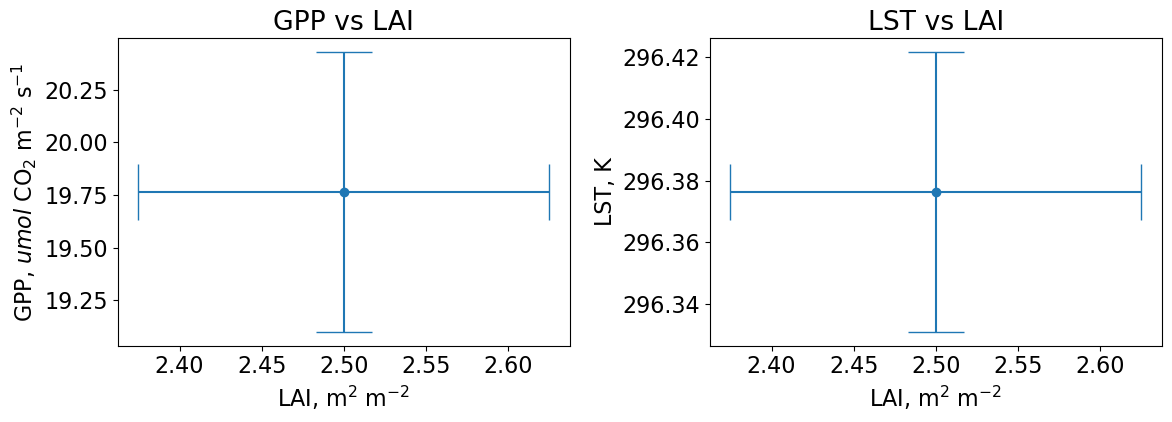

In [14]:
_, axs = plt.subplots(1, 2, figsize=(12, 4.5), tight_layout=True)

ax = axs[0]
ax.errorbar(LAI_values, GPP, xerr=LAI_uncertainties_random, yerr=GPP_ur, capsize=20, marker='o')
ax.set_xlabel('LAI, ' + 'm$^2$ m$^{-2}$')
ax.set_ylabel('GPP, ' + '$umol$ CO$_2$ m$^{-2}$ s$^{-1}$')
ax.set_title('GPP vs LAI')

ax = axs[1]
ax.errorbar(LAI_values, LST, xerr=LAI_uncertainties_random, yerr=LST_ur, capsize=20, marker='o')
ax.set_xlabel('LAI, ' + 'm$^2$ m$^{-2}$')
ax.set_ylabel('LST, ' + 'K')
ax.set_title('LST vs LAI')

### same as above but in the expected parameter ranges

- LAI - 0 - 7 m$^2$ m$^{-2}$
- GPP 0 - 40 $umol$ CO$_2$ m$^{-2}$ s$^{-1}$
- LST 273 - 320 K

(0.0, 7.0)

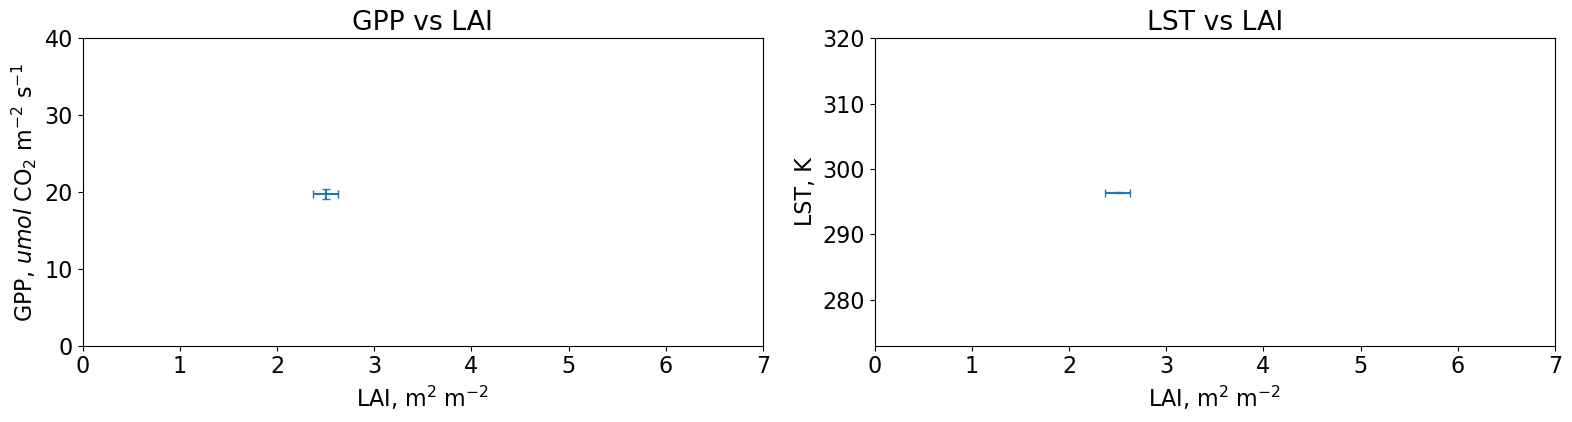

In [15]:
_, axs = plt.subplots(1, 2, figsize=(16, 4.5), tight_layout=True)

ax = axs[0]
ax.errorbar(LAI_values, GPP, xerr=LAI_uncertainties_random, yerr=GPP_ur, capsize=3)
ax.set_xlabel('LAI, ' + 'm$^2$ m$^{-2}$')
ax.set_ylabel('GPP, ' + '$umol$ CO$_2$ m$^{-2}$ s$^{-1}$')
ax.set_title('GPP vs LAI')
ax.set_ylim([0, 40])
ax.set_xlim([0, 7])

ax = axs[1]
ax.errorbar(LAI_values, LST, xerr=LAI_uncertainties_random, yerr=LST_ur, capsize=3)
ax.set_xlabel('LAI, ' + 'm$^2$ m$^{-2}$')
ax.set_ylabel('LST, ' + 'K')
ax.set_title('LST vs LAI')
ax.set_ylim([273, 320])
ax.set_xlim([0, 7])